In [8]:
import cv2, numpy as np
import matplotlib.pyplot as plt
rc = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False}
plt.rcParams.update(rc)
blue = (0,0,255)
red  = (255,0,0)
green = (0,0,255)
white = (255,255,255)
black = (0,0,0)

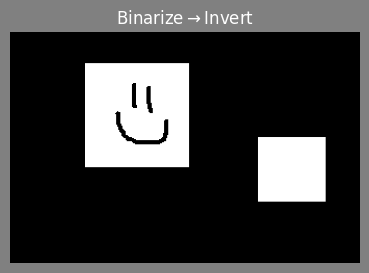

In [19]:
img_rect_path = r'data_processing/media/rect.png'
img_bgr             = cv2.imread(   img_rect_path   , flags=cv2.IMREAD_COLOR)       # 3 channs BGR
img_rgb         = cv2.cvtColor( img_bgr         , cv2.COLOR_BGR2RGB) 
img_gray_bgr        = cv2.cvtColor( img_bgr         , cv2.COLOR_BGR2GRAY)  
_, img_binary = cv2.threshold(img_gray_bgr, 150, 255, cv2.THRESH_BINARY)
img_invert = 255 - img_binary
fig,ax = plt.subplots(1,1, figsize = (6,3), facecolor = 'Gray')
ax.imshow(img_invert, 'gray')
ax.set_title(r'Binarize$\rightarrow$Invert', color='white');

# Find external contours. Draw contours.

Background is black  = 0, objects are white. no black inside white

Text(0.5, 1.0, 'Draw external contours')

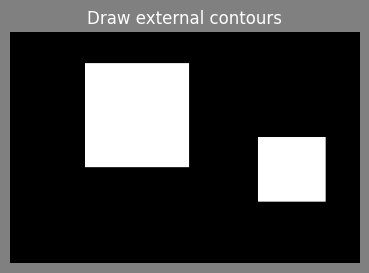

In [11]:
contours_external, _ = cv2.findContours(img_invert, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # cv2.CHAIN_APPROX_NONE

blank_ext = np.zeros_like(img_invert)
cv2.drawContours(blank_ext, contours_external, -1, 255, -1)
fig,ax = plt.subplots(1,1, figsize = (6,3), facecolor = 'Gray')
ax.imshow(blank_ext, 'gray')
ax.set_title(r'Draw external contours', color='white')

# Find contours with hierarchy information.
* Number of rows in hierarchy = number of contours.
* Each row (its order numer) shows info for about its heirarchy. 
* Last entry of each row is this contour's parent: -1  = no parent.
* Other values point to ID in list of contours.

[tutorial_py_contours_hierarchy](https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html)

In [16]:
contours_all, hierarchy = cv2.findContours(img_invert, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
blank_all = np.zeros_like(img_bgr)
print(hierarchy)

[[[ 1 -1 -1 -1]
  [-1  0  2 -1]
  [ 3 -1 -1  1]
  [ 4  2 -1  1]
  [-1  3 -1  1]]]


Can color contours based on hierarchy

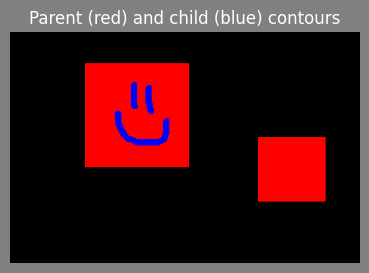

In [17]:

parent_idx = hierarchy[0,:,-1]
parents_where = np.argwhere(parent_idx == -1).flatten()
childre_where = np.argwhere(parent_idx != -1).flatten()

for i, cntr in enumerate(contours_all):
    clr = red if i in parents_where else blue
    cv2.drawContours(blank_all, [cntr] , 0, clr, -1)
    
fig,ax = plt.subplots(1,1, figsize = (6,3), facecolor = 'Gray')
ax.imshow(blank_all)
ax.set_title(r'Parent (red) and child (blue) contours', color='white');

# Bounding rectangles (BBoxes, also  called AABB - Axis Aligned Bounding Box) , cropping and slicing. 
Get bounding box (BB) of contours, or join multiple contours together and get combined BB.

Paste cropped elements on blank canvas via slicing

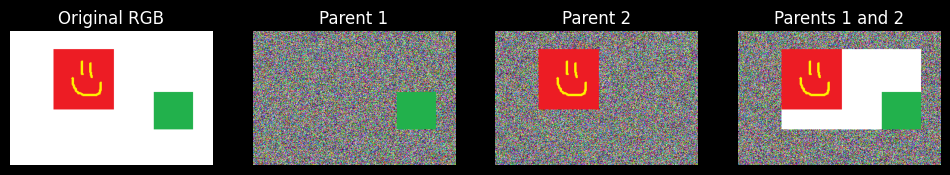

In [30]:
parent_cntrs = [cntr for i,cntr in enumerate(contours_all) if i in parents_where]
xywh_prnt   = [cv2.boundingRect(cntr) for cntr in parent_cntrs]
cropp_all   = [img_rgb[Y:Y+H,X:X+W] for X,Y,W,H in xywh_prnt]

stack_parnent_cntrs = np.vstack(parent_cntrs)

X,Y,W,H = cv2.boundingRect(stack_parnent_cntrs)
cropp_all.append(img_rgb[Y:Y+H,X:X+W])
xywh_prnt.append((X,Y,W,H ))
# predefine blank images filled with noise (for style)
np.random.seed(69)
blank = np.random.uniform(low=0, high= 255, size=(4, *img_rgb.shape)).astype(np.uint8)
blank[0] = img_rgb
for i, (crop, (X,Y,W,H)) in enumerate(zip(cropp_all,xywh_prnt)):
    blank[i+1][Y:Y+H,X:X+W] = crop

fig,ax = plt.subplots(1,len(blank), figsize = (12,3), facecolor = 'black')
titles = ['Original RGB', 'Parent 1', 'Parent 2', 'Parents 1 and 2']
for i,img in enumerate(blank):
    ax[i].imshow(img)
    ax[i].set_title(titles[i], color='white')